12/06/2021

## Load libraries

In [ ]:
import pandas as pd
import numpy as np

import os
import sys

from sklearn.neural_network import MLPClassifier

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

# to play the audio files
from IPython.display import Audio

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import lightgbm as lgb

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Load and set data paths

In [ ]:
Crema = "/content/drive/MyDrive/Colab Notebooks/speech/dataset/cremad/AudioWAV/"

In [ ]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()


,Emotions,Path
0,happy,/content/drive/MyDrive/Colab Notebooks/speech/...
1,happy,/content/drive/MyDrive/Colab Notebooks/speech/...
2,fear,/content/drive/MyDrive/Colab Notebooks/speech/...
3,fear,/content/drive/MyDrive/Colab Notebooks/speech/...
4,disgust,/content/drive/MyDrive/Colab Notebooks/speech/...


In [ ]:
Cremad_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/speech/dataset/cremad/emotion_path.csv')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


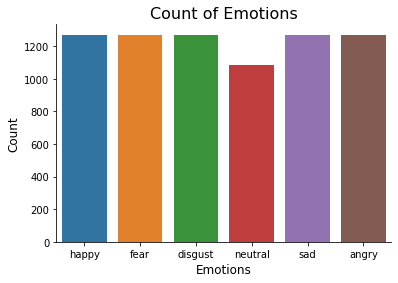

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(Cremad_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

## Feature Extraction

In [ ]:
observed_emotions=sorted(['fear', 'happy', 'sad', 'angry'])

In [ ]:
observed_emotions

['angry', 'fear', 'happy', 'sad']

In [ ]:
num_mfcc=13

In [ ]:
def extract_feature(path, mfcc, chroma, mel, tempo):
  data, sample_rate = librosa.load(path, res_type='kaiser_fast')
  if chroma:
    stft = np.abs(librosa.stft(data))

  result=np.array([])
  if mfcc:
    mfccs=np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=num_mfcc).T, axis=0)
    result=np.hstack((result, mfccs))
  if chroma:
    chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result=np.hstack((result, chroma))
  if mel:
    mel=np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result=np.hstack((result, mel))
  if tempo:
    tempo=np.mean(librosa.feature.tempogram(y=data, sr=sample_rate).T, axis=0)
    result=np.hstack((result, tempo))

  return result

In [ ]:
X, Y = [], []
for path, emotion in zip(Cremad_df.Path, Cremad_df.Emotions):
  if emotion not in observed_emotions:
    continue
  feature = extract_feature(path, mfcc=False, chroma=False, mel=True, tempo=False)
  X.append(feature)
  Y.append(emotion)

In [ ]:
len(X), len(Y), Cremad_df.Path.shape

(5084, 5084, (7442,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('/content/drive/MyDrive/Colab Notebooks/speech/dataset/cremad/mel_features.csv', index=0)
Features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,labels
0,0.076833,0.030737,0.061028,0.081898,0.046983,0.046682,0.185286,1.064163,0.952967,1.010579,1.109322,1.736680,3.320479,7.171905,6.498925,5.798558,7.476932,10.674026,13.549254,4.204493,14.216737,14.409835,2.196486,1.269828,0.974430,1.407033,3.226888,2.822817,1.978801,2.767190,4.145090,1.531667,0.717661,0.529532,2.836708,2.795673,1.829404,1.580155,1.661133,2.539765,...,0.041259,0.052720,0.026409,0.124675,0.080615,0.068720,0.035598,0.009643,0.003180,0.001634,0.000573,0.001007,0.001570,0.002691,0.003597,0.005950,0.007294,0.005611,0.006267,0.005680,0.004223,0.003144,0.000948,0.000207,0.000055,2.361743e-05,6.259726e-06,1.045090e-06,6.477228e-09,2.217579e-09,2.431702e-09,2.498823e-09,1.997063e-09,1.707204e-09,1.595727e-09,1.237794e-09,1.764120e-09,1.912552e-09,1.625368e-09,happy
1,0.046559,0.029116,0.064096,0.109162,0.217946,0.690346,1.395999,0.942536,1.450985,0.852693,0.369703,0.752590,1.780183,2.966136,3.849347,0.470726,1.289655,2.574431,2.957825,7.731913,5.124743,1.307118,0.200186,0.090035,0.064821,0.910954,0.777657,0.118238,0.376992,0.680684,1.654895,0.340065,0.023265,0.044356,0.173880,0.232484,0.257710,0.153174,0.279318,0.182870,...,0.003270,0.002771,0.001190,0.000810,0.001308,0.000938,0.001170,0.001200,0.000716,0.001077,0.000700,0.000841,0.000647,0.000693,0.000732,0.000793,0.001397,0.000533,0.000586,0.000555,0.000333,0.000137,0.000055,0.000020,0.000004,7.381458e-07,4.991731e-08,2.016636e-09,2.160071e-10,1.893571e-10,1.814714e-10,1.492693e-10,2.272426e-10,1.929704e-10,3.066508e-10,1.671939e-10,2.916499e-10,2.593199e-10,1.517384e-10,happy
2,0.058857,0.023937,0.055691,0.109114,0.061035,0.126132,0.392168,1.118926,3.271797,4.100485,4.907799,0.579800,0.076296,0.057966,0.085716,0.063021,0.139486,0.952193,2.977605,3.059296,8.881009,9.359259,1.218928,0.526419,0.400553,0.337032,0.387572,0.137893,0.678827,2.565876,11.902858,6.689280,0.535942,0.130106,0.994555,0.658200,0.230561,0.134756,0.127539,0.101044,...,0.010870,0.013965,0.004976,0.045715,0.030037,0.009058,0.011689,0.002812,0.002084,0.001277,0.001565,0.002221,0.003241,0.003994,0.003977,0.002401,0.004122,0.003226,0.003202,0.003066,0.002850,0.001265,0.000447,0.000151,0.000040,7.197897e-06,2.305826e-07,2.132078e-08,5.265176e-10,3.795984e-10,4.813825e-10,5.271771e-10,1.025039e-09,4.272844e-10,5.892366e-10,3.384375e-10,6.220975e-10,3.963903e-10,6.704314e-10,fear
3,0.089417,0.043337,0.064568,0.077344,0.053868,0.050667,0.104624,0.119529,0.142349,0.031927,0.016647,0.014181,0.022433,0.094759,0.202395,0.466302,0.625785,5.083666,9.595825,42.822166,97.292770,109.934952,68.821709,63.094906,37.134239,81.886009,60.915936,1.730652,0.264138,0.406198,0.530102,0.131757,0.050231,0.112589,0.259326,0.130141,0.385837,0.360597,2.762814,16.475212,...,0.388569,0.177909,0.138913,0.378778,0.178972,0.094732,0.101731,0.049609,0.097035,0.073922,0.006838,0.005580,0.009142,0.010743,0.018780,0.021374,0.031865,0.025645,0.027884,0.040327,0.029941,0.008681,0.003957,0.001187,0.000225,4.792569e-05,1.928453e-06,9.601128e-08,4.126726e-09,4.181601e-09,3.185698e-09,3.375830e-09,5.281182e-09,7.663287e-09,2.881841e-09,2.500057e-09,2.059050e-09,2.739120e-09,2.659726e-09,fear
4,0.061285,0.027733,0.060389,0.090851,0.048972,0.047888,0.091910,0.095385,0.118773,0.220061,0.289259,0.498829,0.965216,5.323498,4.686775,0.395963,0.386031,1.173238,1.899026,5.511223,6.432559,5.685246,1.528582,0.560362,0.195801,0.417377,0.431062,0.155534,0.349979,0.377279,0.806367,0.227697,0.026932,0.048938,0.124893,0.059002,0.040438,0.049543,0.071956,0.107505,...,0.001913,0.001806,0.001005,0.001807,0.001853,0.002765,0.003716,0.001740,0.000839,0.000557,0.000423,0.000732,0.001042,0.001541,0.002110,0.003972,0.007682,0.008594,0.009143,0.009699,0.007874,0.005866,0.002503,0.000954,0.000528,7.000857e-05,

## Data Preparation

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/speech/dataset/cremad/mel_features.csv')
dataset.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,labels
0,0.076833,0.030737,0.061028,0.081898,0.046983,0.046682,0.185286,1.064163,0.952967,1.010579,1.109322,1.736680,3.320479,7.171905,6.498925,5.798558,7.476932,10.674026,13.549254,4.204493,14.216737,14.409835,2.196486,1.269828,0.974430,1.407033,3.226888,2.822817,1.978801,2.767190,4.145090,1.531667,0.717661,0.529532,2.836708,2.795673,1.829404,1.580155,1.661133,2.539765,...,0.041259,0.052720,0.026409,0.124675,0.080615,0.068720,0.035598,0.009643,0.003180,0.001634,0.000573,0.001007,0.001570,0.002691,0.003597,0.005950,0.007294,0.005611,0.006267,0.005680,0.004223,0.003144,0.000948,0.000207,0.000055,2.361743e-05,6.259726e-06,1.045090e-06,6.477228e-09,2.217579e-09,2.431702e-09,2.498823e-09,1.997063e-09,1.707204e-09,1.595727e-09,1.237794e-09,1.764120e-09,1.912552e-09,1.625368e-09,happy
1,0.046559,0.029116,0.064096,0.109162,0.217946,0.690346,1.395999,0.942536,1.450985,0.852693,0.369703,0.752590,1.780183,2.966136,3.849347,0.470726,1.289655,2.574431,2.957825,7.731913,5.124743,1.307118,0.200186,0.090035,0.064821,0.910954,0.777657,0.118238,0.376992,0.680684,1.654895,0.340065,0.023265,0.044356,0.173880,0.232484,0.257710,0.153174,0.279318,0.182870,...,0.003270,0.002771,0.001190,0.000810,0.001308,0.000938,0.001170,0.001200,0.000716,0.001077,0.000700,0.000841,0.000647,0.000693,0.000732,0.000793,0.001397,0.000533,0.000586,0.000555,0.000333,0.000137,0.000055,0.000020,0.000004,7.381458e-07,4.991731e-08,2.016636e-09,2.160071e-10,1.893571e-10,1.814714e-10,1.492693e-10,2.272426e-10,1.929704e-10,3.066508e-10,1.671939e-10,2.916499e-10,2.593199e-10,1.517384e-10,happy
2,0.058857,0.023937,0.055691,0.109114,0.061035,0.126132,0.392168,1.118926,3.271797,4.100485,4.907799,0.579800,0.076296,0.057966,0.085716,0.063021,0.139486,0.952193,2.977605,3.059296,8.881009,9.359259,1.218928,0.526419,0.400553,0.337032,0.387572,0.137893,0.678827,2.565876,11.902858,6.689280,0.535942,0.130106,0.994555,0.658200,0.230561,0.134756,0.127539,0.101044,...,0.010870,0.013965,0.004976,0.045715,0.030037,0.009058,0.011689,0.002812,0.002084,0.001277,0.001565,0.002221,0.003241,0.003994,0.003977,0.002401,0.004122,0.003226,0.003202,0.003066,0.002850,0.001265,0.000447,0.000151,0.000040,7.197897e-06,2.305826e-07,2.132078e-08,5.265176e-10,3.795984e-10,4.813825e-10,5.271771e-10,1.025039e-09,4.272844e-10,5.892366e-10,3.384375e-10,6.220975e-10,3.963903e-10,6.704314e-10,fear
3,0.089417,0.043337,0.064568,0.077344,0.053868,0.050667,0.104624,0.119529,0.142349,0.031927,0.016647,0.014181,0.022433,0.094759,0.202395,0.466302,0.625785,5.083666,9.595825,42.822166,97.292770,109.934952,68.821709,63.094906,37.134239,81.886009,60.915936,1.730652,0.264138,0.406198,0.530102,0.131757,0.050231,0.112589,0.259326,0.130141,0.385837,0.360597,2.762814,16.475212,...,0.388569,0.177909,0.138913,0.378778,0.178972,0.094732,0.101731,0.049609,0.097035,0.073922,0.006838,0.005580,0.009142,0.010743,0.018780,0.021374,0.031865,0.025645,0.027884,0.040327,0.029941,0.008681,0.003957,0.001187,0.000225,4.792569e-05,1.928453e-06,9.601128e-08,4.126726e-09,4.181601e-09,3.185698e-09,3.375830e-09,5.281182e-09,7.663287e-09,2.881841e-09,2.500057e-09,2.059050e-09,2.739120e-09,2.659726e-09,fear
4,0.061285,0.027733,0.060389,0.090851,0.048972,0.047888,0.091910,0.095385,0.118773,0.220061,0.289259,0.498829,0.965216,5.323498,4.686775,0.395963,0.386031,1.173238,1.899026,5.511223,6.432559,5.685246,1.528582,0.560362,0.195801,0.417377,0.431062,0.155534,0.349979,0.377279,0.806367,0.227697,0.026932,0.048938,0.124893,0.059002,0.040438,0.049543,0.071956,0.107505,...,0.001913,0.001806,0.001005,0.001807,0.001853,0.002765,0.003716,0.001740,0.000839,0.000557,0.000423,0.000732,0.001042,0.001541,0.002110,0.003972,0.007682,0.008594,0.009143,0.009699,0.007874,0.005866,0.002503,0.000954,0.000528,7.000857e-05,

In [ ]:
dataset.labels.value_counts()

angry    1271
fear     1271
sad      1271
happy    1271
Name: labels, dtype: int64

## Modeling

### MLPClassifier

In [ ]:
X = dataset.iloc[:, :-1].values
Y = dataset.iloc[:, -1].values

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(np.array(X), Y, test_size = 0.25, random_state = 9)

In [ ]:
x_train.shape

(3813, 128)

In [ ]:
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=1000)

In [ ]:
model.fit(x_train, y_train)

MLPClassifier(activation='relu', alpha=0.01, batch_size=256, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(300,), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

### LightGBM

In [ ]:
data = dataset.copy()
data.labels = data.labels.map({'angry':0, 'fear':1, 'happy':2, 'sad':3})

In [ ]:
data.labels.value_counts()

3    1271
2    1271
1    1271
0    1271
Name: labels, dtype: int64

In [ ]:
X = data.iloc[:, :-1].values
Y = data.iloc[:, -1].values

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 0)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=0)

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_valid = sc.transform(x_valid)

In [ ]:
NUM_CLASS = 4

params = {}
params['learning_rate'] = 0.01
params['boosting_type'] = 'gbdt'
params['objective'] = 'multiclass'
params['metric'] = 'multi_logloss'
params['num_leaves'] = 100
params['min_data'] = 100
params['max_depth'] = 50
params['num_class'] = NUM_CLASS
params['max_bin'] = 150 # small max_bin causes faster speed and large value improves accuracy
params['bagging_freq'] = 100
params['feature_fraction'] = 0.6 # deal with column
params['bagging_fraction'] = 0.6
# params['device'] = 'gpu'
#params['num_iterations'] = 1000
#params['early_stopping_rounds'] = 100# the rule of thumb is to have it at 10% of your num_iterations

In [ ]:
x_test.shape

(1271, 128)

In [ ]:
import lightgbm as lgb

In [ ]:
dtrain = lgb.Dataset(x_train, y_train)
dvalid = lgb.Dataset(x_valid, y_valid)
lgb_model = lgb.train(params, 
                          dtrain, 
                          num_boost_round=10000,
                          early_stopping_rounds=1000,
                          valid_sets=(dtrain, dvalid), 
                          valid_names=('train','valid'),
                          verbose_eval = 100)

Training until validation scores don't improve for 1000 rounds.
[100]	train's multi_logloss: 1.04893	valid's multi_logloss: 1.08588
[200]	train's multi_logloss: 0.900473	valid's multi_logloss: 0.981927
[300]	train's multi_logloss: 0.814255	valid's multi_logloss: 0.932924
[400]	train's multi_logloss: 0.751698	valid's multi_logloss: 0.9126
[500]	train's multi_logloss: 0.699586	valid's multi_logloss: 0.895098
[600]	train's multi_logloss: 0.654962	valid's multi_logloss: 0.890734
[700]	train's multi_logloss: 0.615736	valid's multi_logloss: 0.881952
[800]	train's multi_logloss: 0.578076	valid's multi_logloss: 0.87432
[900]	train's multi_logloss: 0.541618	valid's multi_logloss: 0.868719
[1000]	train's multi_logloss: 0.511844	valid's multi_logloss: 0.867818
[1100]	train's multi_logloss: 0.48508	valid's multi_logloss: 0.865721
[1200]	train's multi_logloss: 0.457208	valid's multi_logloss: 0.863133
[1300]	train's multi_logloss: 0.43263	valid's multi_logloss: 0.867942
[1400]	train's multi_logloss:

## Experiment results

### MLP

In [ ]:
preds = model.predict(x_test)

In [ ]:
results = pd.DataFrame()
results['Actual'] = y_test
results['Predicted'] = preds

results.head()

,Actual,Predicted
0,happy,angry
1,fear,happy
2,fear,sad
3,sad,fear
4,angry,happy


In [ ]:
d = results[(results.Actual=='sad') & (results.Predicted=='sad')]
d.shape

(248, 2)

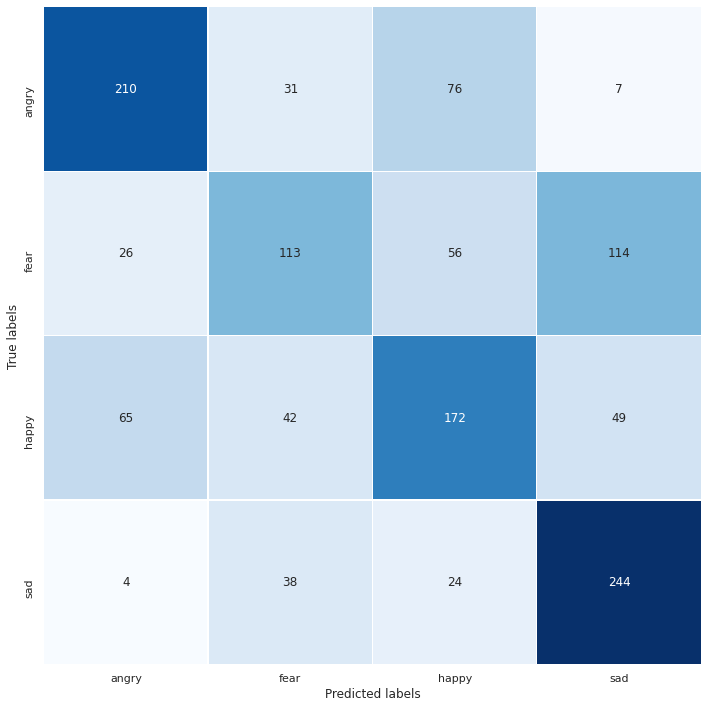

In [ ]:
cm = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm,
                     index=observed_emotions,
                     columns=observed_emotions)
plt.figure(figsize=(10, 10))

sns.set(font_scale=1)


ax = sns.heatmap(df_cm, annot=True, square=True, fmt='d', linewidths=.2, cbar=0, cmap=plt.cm.Blues)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.tight_layout()

name = 'mel feature 58%.png'
plt.savefig('/content/drive/MyDrive/Colab Notebooks/speech/dataset/cremad/Confusion matrix/mlp Confusion matrix for ' + name)

plt.show()

In [ ]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

       angry       0.69      0.65      0.67       324
        fear       0.50      0.37      0.42       309
       happy       0.52      0.52      0.52       328
         sad       0.59      0.79      0.67       310

    accuracy                           0.58      1271
   macro avg       0.58      0.58      0.57      1271
weighted avg       0.58      0.58      0.57      1271



In [ ]:
import pickle

filename =l = 'mel_mlp_0.58.sav'
pickle.dump(model, open('/content/drive/MyDrive/Colab Notebooks/speech/dataset/cremad/Models/' + filename, 'wb'))
loaded_model = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/speech/dataset/cremad/Models/' + filename, 'rb'))

### LGB

In [ ]:
preds = lgb_model.predict(x_test)

In [ ]:
predictions = []

for x in preds:
    predictions.append(np.argmax(x))

In [ ]:
results = pd.DataFrame()
results['Actual'] = y_test
results['Predicted'] = predictions

results['Actual'] = results['Actual'].map({0:'angry', 1:'fear', 2:'happy', 3:'sad'})
results['Predicted'] = results['Predicted'].map({0:'angry', 1:'fear', 2:'happy', 3:'sad'})
results.head()

,Actual,Predicted
0,happy,fear
1,sad,sad
2,fear,fear
3,sad,sad
4,sad,sad


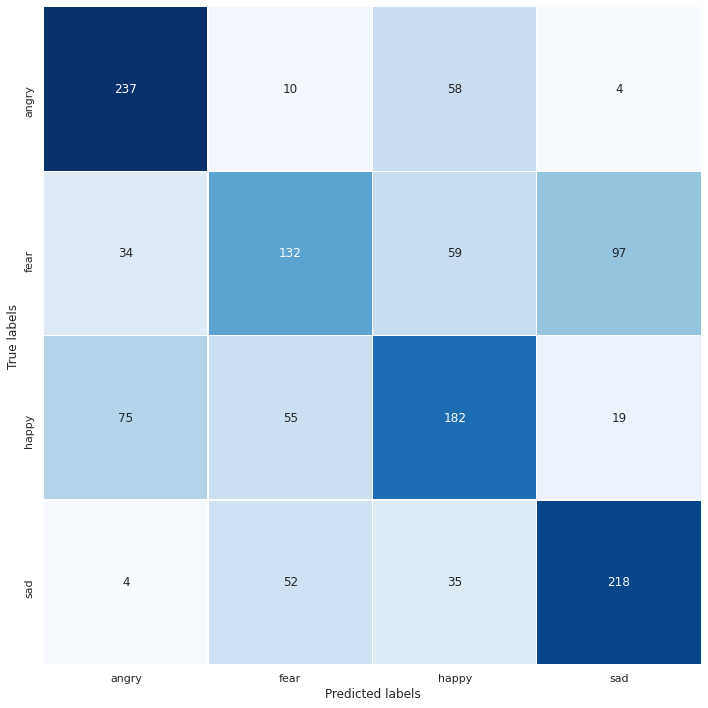

In [ ]:
cm = confusion_matrix(y_test, predictions)
df_cm = pd.DataFrame(cm,
                     index=observed_emotions,
                     columns=observed_emotions)

plt.figure(figsize=(10, 10))

sns.set(font_scale=1)

ax = sns.heatmap(df_cm, annot=True, square=True, fmt='d', linewidths=.2, cbar=0, cmap=plt.cm.Blues)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.tight_layout()

name = 'mel feature 61%.png'
plt.savefig('/content/drive/MyDrive/Colab Notebooks/speech/dataset/cremad/Confusion matrix/lgbm Confusion matrix for ' + name)

plt.show()

In [ ]:
print(classification_report(y_test, predictions, target_names=observed_emotions))

              precision    recall  f1-score   support

       angry       0.68      0.77      0.72       309
        fear       0.53      0.41      0.46       322
       happy       0.54      0.55      0.55       331
         sad       0.64      0.71      0.67       309

    accuracy                           0.61      1271
   macro avg       0.60      0.61      0.60      1271
weighted avg       0.60      0.61      0.60      1271



In [ ]:
import pickle

filename = 'mel_lgbm_0.61.sav'
pickle.dump(lgb_model, open('/content/drive/MyDrive/Colab Notebooks/speech/dataset/cremad/Models/' + filename, 'wb'))
loaded_model = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/speech/dataset/cremad/Models/' + filename, 'rb'))